In [ ]:
# Bot check

# HW_ID: phds_hw10
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm
from scipy import integrate
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm as tqdm

sns.set_theme(font_scale=1.3, palette='Set2')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Профиль биология**

Рассмотрим данные об экспрессии белка DYRK1_A в мышах в разные дни. Загрузите датасет с сайта курса. Постройте гистограммы распределений и проведите t-test, чтобы выяснить, различается ли средний уровень экспрессии белка в день 1 и 2.

In [ ]:
protein = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/data/mice_expression.csv')

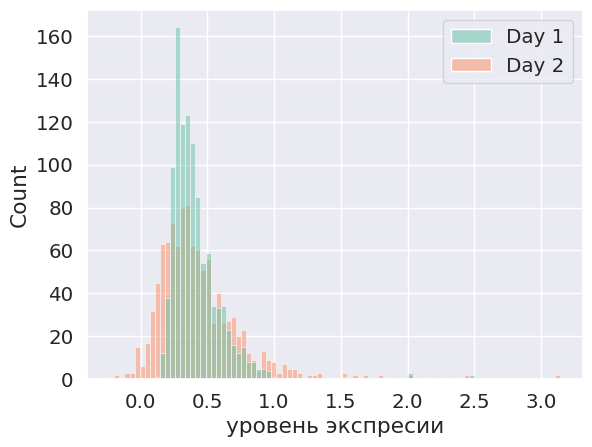

In [ ]:
sns.histplot(protein)

plt.xlabel('уровень экспресии')
plt.show()

In [ ]:
sps.ttest_rel(protein['Day 1'], protein['Day 2'])

TtestResult(statistic=-2.1925908404058365, pvalue=0.028550423276649355, df=1076)

Объясните выбор теста и сделайте выводы.

**Вывод:** выборки связанные, поэтому такой т-тест, одни и те же особи мышей, по нарисованным гистограмма мы ожидали отличие распределений, но о среднем не так очевидно, используя т-тест подтвердилось различие, т.е. смогли отвергнуть гипотезу о равенстве средних уровней экспресси белка в первый и второй день (пвалью меньше 0.05), хотя и не очень уверенно

## Задача 2


### **Профиль физика**


Как известно, в квантовой механике частицы можно разделить на две группы: бозоны (с целым спином) и фермионы (с полуцелым спином). Так как бозоны могут занимать одно и то же квантовое состояние, а фермионы не могут, то системы из нескольких таких частиц будут иметь различные распределения по энергиям:
$$
    n_\textbf{p}(\varepsilon) = \frac{1}{e^\frac{\varepsilon - \mu}{k_БT} \pm 1},
$$
где $\varepsilon$ &mdash; энергия частицы, $\mu$ &mdash; химический потенциал, а $n(\varepsilon)$ &mdash; среднее число частиц, находящихся в квантовом состоянии **p** с энергией $\varepsilon$. Знак "$+$" соответствует статистике для ферми-частиц (распределение Ферми-Дирака), "$-$" &mdash; статистике для бозе-частиц (распределение Бозе-Эйнштейна). Чтобы перейти к плотности вероятности по энергиям, необходимо учесть плотность состояний и не забыть про нормировочный множитель. Тогда

$$
    p(\varepsilon) = \frac{1}{Z}\frac{\sqrt{\varepsilon}}{e^\frac{\varepsilon - \mu}{k_БT} \pm 1},
$$
$$
    Z = \int \limits_0^\infty \frac{\sqrt{\varepsilon}}{e^\frac{\varepsilon - \mu}{k_БT} \pm 1} d\varepsilon
$$

Однако при высоких температурах идеальный газ из таких частиц будет иметь примерно одинаковое распределение, а именно больцмановское:
$$
    n_\textbf{p}(\varepsilon) = e^\frac{\mu - \varepsilon}{k_БT}
$$

В этой задаче вам предлагается посмотреть, как данный факт можно отследить при помощи t-test для независимых выборок. Иными словами, посмотреть как распределения энергий бозе- и ферми-газов отличаются статистически друг от друга при различных температурах.

Для наших целей разумно будет отказаться от размерных коэффициентов и договориться о следующем. Пусть $\varepsilon$ и $T$ &mdash; некие безразмерные величины, характеризующие энергию и температуру, а химический потенциал равен $\mu = -T \ln T$, что, в целом, недалеко от истины.

Зададим вид распределений

In [ ]:
P_f = lambda e, T: e**0.5 / (np.exp((e + T * np.log(T)) / T) + 1)
P_b = lambda e, T: e**0.5 / (np.exp((e + T * np.log(T)) / T) - 1)

Чтобы интеграл от плотности давал единицу, важно задать нормировочный множитель:

In [ ]:
T = 1.1

Z_f = integrate.quad(P_f, 0, 10 * T, args=(T))[0]
Z_b = integrate.quad(P_b, 0, 10 * T, args=(T))[0]

Визуализируем плотность вероятности:

In [ ]:
x_vals = np.linspace(0, 10 * T, 1000)
y_vals_f = P_f(x_vals, T)
y_vals_b = P_b(x_vals, T)
plt.figure(1)
plt.plot(x_vals, y_vals_f / Z_f, 'r', label='P_f(x)')
plt.plot(x_vals, y_vals_b / Z_b, 'b', label='P_b(x)')
plt.xlabel('Энергия, у. е.')
plt.ylabel('Плотность вероятности')
plt.legend(loc='upper right', shadow=True)
plt.show()

Научимся генериовать выборки из интересующих нас распределений. Чтобы получить такие выборки воспользуемся алгоритмом Метрополиса-Гастингса.

In [ ]:
def sample_gas(T, P, steps=20000, sigma=3, cool_down=20):

    Q = lambda t1, t0: np.exp(-(t0)**2/(2 * (sigma * T)**2)/ \
        (np.sqrt(2 * np.pi) * (sigma * T)))

    Z = integrate.quad(P, 0, 100 * T, args=(T))[0]

    x0 = np.random.uniform(0, 2 * T)
    xt = x0

    samples = []

    for i in range(steps):
        xt_candidate = np.abs(np.random.normal(loc=xt, scale=sigma * T))

        accept_prob = (P(xt_candidate, T) * Q(xt, xt_candidate))/ \
            (P(xt, T) * Q(xt_candidate, xt))

        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate

        if i % cool_down == 0:
            samples.append(xt)

    burn_in = 1000 // cool_down

    samples = np.array(samples[burn_in:])

    return samples, Z

In [ ]:
samples_f, Z_f = sample_gas(T, P_f)
samples_b, Z_b = sample_gas(T, P_b)

In [ ]:
plt.hist(samples_f, bins=20, histtype='bar', facecolor='r', alpha=0.3, density=True, label='f')
plt.hist(samples_b, bins=20, histtype='bar', facecolor='b', alpha=0.3, density=True, label='b')
plt.plot(x_vals, y_vals_f/Z_f, 'r', label='P_f(x)')
plt.plot(x_vals, y_vals_b/Z_b, 'b', label='P_b(x)')
plt.xlabel('Энергия, у. е.')
plt.ylabel('Плотность вероятности')
plt.title('Metropolis Hastings sampling')
plt.legend(loc='upper right', shadow=True)
plt.show()


**1.**
Зафиксируйте значение "температуры" `T` и проведите несколько АА-тестов для выборок ферми-газа, чтобы убедиться в корректности работы нашего теста. Для этого 2000 раз сгенерируйте две выборки для ферми-газа и посчитайте p-value t-test независимых выборок.

In [ ]:
# ваш код

Вспомните, какое распределение имеет величина p-value в случае, если нулевая гипотеза верна?

**Ответ:**

Постройте гистограмму значений p-value. Корректно ли работает t-test на ваших данных?

In [ ]:
# ваш код

**Вывод:**

**2.** С помощью проведения AB-тестов узнайте, какова мощность критерия для разных значений "температуры" (постройте график). Для наглядности используйте логарифмическое разбиение шкалы "температуры" `np.logspace` и стройте график в логарифмическом масштабе

In [ ]:
Ts = np.logspace(0.001, 1, 20)

In [ ]:
# ваш код

**Вывод:**

### **Профиль биология**


Рассмотрим [данные по медицинским страховкам](https://www.kaggle.com/datasets/gauravduttakiit/medical-insurance-cost?select=Train_Data.csv):

Скачайте файл с тренировочными данными и оставьте колонку:
* `charges` &mdash; стоимость страховки человека.

In [ ]:
!unzip '/content/drive/MyDrive/Colab_Notebooks/data/insurance.zip'

Archive:  /content/drive/MyDrive/Colab_Notebooks/data/insurance.zip
  inflating: Sample_Submission.csv   
  inflating: Test_Data.csv           
  inflating: Train_Data.csv          


In [ ]:
train_insurance = pd.read_csv('/content/Train_Data.csv')

In [ ]:
data = train_insurance['charges']

In [ ]:
data

,charges
0,3279.868550
1,21454.494239
2,1720.353700
3,6801.437542
4,11946.625900
...,...
3625,10987.324964
3626,11735.844352
3627,10602.385000
3628,8976.140452


Министерство здравоохранения хочет провести AB-тест для оценки значимости эффекта от новых рекомендаций по употреблению витаминов и использовать для этого t-test независимых выборок. Ожидается, что новые рекомендации повысят здоровье общества и снизят затраты на страховку. На время тестирования решено выдать рекомендации случайной группе из 1000 людей.

**1.**
Проведите 2000 случайных AA-тестов для проверки правильности работы t-test. Использовать нужно группы одинакого размера, конечно же, они не должны пересекаться.

In [ ]:
data_a_values = data[:int(len(data)/2)].values
data_b_values = data[int(len(data)/2):].values

In [ ]:
num_tests = 2000
sample_size = 30

pvals = []

for i in range(num_tests):
    indices_a = np.random.choice(len(data_a_values), size=sample_size)
    indices_b = np.random.choice(len(data_b_values), size=sample_size)

    group_a = data_a_values[indices_a]
    group_b = data_b_values[indices_b]

    _, p_value = sps.ttest_ind(group_a, group_b)

    pvals.append(p_value)

Вспомните, какое распределение имеет величина p-value в случае, если нулевая гипотеза верна?

**Ответ:** равномерное U[0, 1]

Постройте гистограмму значений p-value. Корректно ли работает t-test на ваших данных?

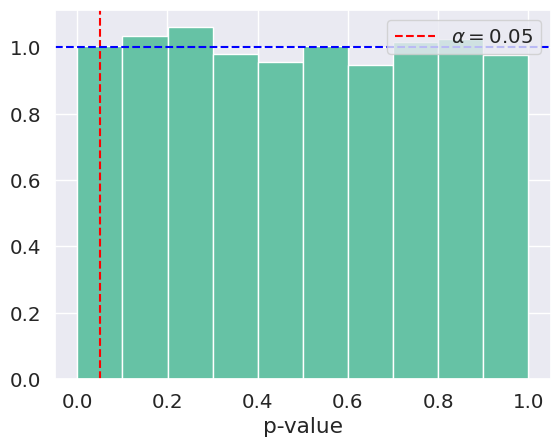

In [ ]:
plt.hist(pvals, density=True)
plt.xlabel('p-value')
plt.axvline(x=0.05, color='red', linestyle='--', label=r'$\alpha=0.05$')
plt.axhline(y=1.0, color='blue', linestyle='--')

plt.legend()
plt.show()

**Вывод:** в ходе АА теста хотим убедиться в применимости его к нашим данным, т.е в отсутствии эффекта по построению (в предположении
справедливости H0) его и не наблюдаем (только на уровне ошибки первого рода), а также подтверждаем распределение пвалью

**2.** Зафиксируйте две выборки одинакового размера: контрольную и тестовую. С помощью проведения AB-теста выясните, какова мощность теста для разных значений эффекта. Схема проведения аналогична предыдущему пункту, но к тестовой группе нужно добавить отрицательное смещение.

При добавлении искусственного смещения рекомендуется также добавлять небольшой шум для каждого человека. Поясните, для чего это может быть полезно. Сделайте выводы.

In [ ]:
control = data_a_values
test = data_b_values
len(control) == len(test)

True

In [ ]:
n_iter = 2000
alpha = 0.05
n_reject = []
sample_size = 100
shifts = np.linspace(0, np.mean(test), 21)

for loc in tqdm(shifts):
    n_reject.append(0)
    for _ in range(n_iter):
        indices_a = np.random.choice(len(control), size=sample_size)
        indices_b = np.random.choice(len(test), size=sample_size)
        group_a = control[indices_a]
        group_b = test[indices_b] - loc
        n_reject[-1] += sps.ttest_ind(group_a, group_b).pvalue < alpha

100%|██████████| 21/21 [01:32<00:00,  4.41s/it]


Text(0, 0.5, 'Мощность')

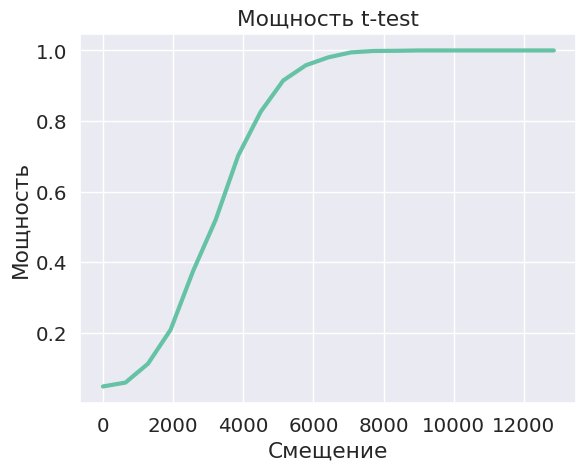

In [ ]:
plt.plot(shifts, np.array(n_reject)/n_iter, lw=3)
plt.title('Мощность t-test')
plt.xlabel('Смещение')
plt.ylabel('Мощность')

In [ ]:
np.mean

12851.622705277025

**Вывод:** оценивая мощность мы хотим понять как хорошо отвергаем на альтернативе, тк генерируем с эффектом, шум позволяет проверить, насколько результаты тестов или моделей устойчивы к изменениям в данных, насколько значимыми являются выявленные эффекты, мощность растет с увеличением сдвига и устойчиво принимает значение единица где-то со смещения в 50%

## Задача 3


### **Профиль физика**


Рассмотрим [данные о RGB (Red Giant Branch) и
HeB (Helium Burning) звездах](https://www.kaggle.com/datasets/fernandolima23/classification-in-asteroseismology?select=classification_in_asteroseismology.csv):

Датасет содержит информацию о звездах, целевая переменная — класс звезд.

С помощью методов дисперсионного анализа исследуйте, по каким параметрам наблюдается различие между двумя рассматриваемыми классами (звездами RGB и HeB). При возможности оцените также степень различия, в т.ч. доверительный интервал.

Скачайте файл и визуализируйте колонки (например, с помощью pairplot):
* `Dnu` &mdash; разделение мод с одинаковой степенью и последовательным порядком;
* `numax` &mdash; частота максимальной мощности колебаний;
* `epsilon` &mdash; расположение режима l=0 ;
* `Pop` &mdash; Population (0 = RGB, 1 = HeB)

In [ ]:
data = <...>

SyntaxError: invalid syntax (<ipython-input-84-27d68bc1049e>, line 1)

In [ ]:
<...> # визуализация

Насколько сильно отличаются распределения между классами? Есть ли очевидные отличия, сдвиг?

**Вывод:**

Оцените, по каким признакам различаются классы, степень различия (сдвиг) и доверительный интервал сдвига. В качестве доверительного интервала используйте бутстрепный квантильный. Объясните выбор статистического теста.

*Подсказка*: выбирая статистический тест и интерпретируя результаты, помните о нулевой гипотезе и мощности. Например, немного об этом в контексте АВ тестов можно почитать [здесь](https://habr.com/ru/companies/avito/articles/709596/).

In [ ]:
def shift(x, y):
    '''Вычисление оценки параметра сдвига из критерия ранговых сумм Уилкоксона'''
    W = <...>
    return np.median(W)

def estimation(data, target, feature, p_values, shifts, ci_lefts, ci_rights, alpha=0.05):
    '''Вычисление оценки параметра сдвига, бутстрепного доверительного интервала для него, а также величины p-value.

    Аргументы:
    data -- pd.DataFrame данных эксперимента
    target -- название колонки, содержащей информацию о группе (A/B)
    feature -- название колонки с переменной, по которой проводим сравнение между группами
    p_values -- массив для сохранения величины p-value
    shifts -- массив для сохранения величины параметра сдвига
    ci_lefts -- массив для сохранения величины левой границы доверительного интервала
    ci_rights -- массив для сохранения величины правой границы доверительного интервала
    alpha -- уровень значимости
    '''
    x = <...>
    y = <...>

    p_values.append(<...>)

    shifts.append(shift(x, y))

    ci_bootst = <...> # бутстрепный доверительный интервал
    ci_lefts.append(ci_bootst[0])
    ci_rights.append(ci_bootst[1])


In [ ]:
p_values, shifts, ci_lefts, ci_rights = [], [], [], []
for column in tqdm(data.columns[1:]):
    estimation(<...>)

In [ ]:
results = {'feature': data.columns[1:],
           'p_value': p_values,
           'shift': shifts,
           'ci_left': ci_lefts,
           'ci_right': ci_rights}
results = pd.DataFrame(results)

In [ ]:
results

*Замечание.* Строго говоря, необходима поправка на множественное тестирование

Какой тест вы использовали и почему? Какие выводы можно сделать по p_value? Как доверительный интервал подтверждает эти выводы? Дополнительно: обратите внимание на `epsilon`: корректно ли оценивать сдвиг между распределениями по этой величине?

**Вывод:**

### **Профиль биология**


Рассмотрим [данные о расстройствах сна](https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset?select=Sleep_health_and_lifestyle_dataset.csv):

Датасет содержит информацию об образе жизни людей, целевая переменная — есть ли у них расстройство сна.

С помощью методов дисперсионного анализа исследуйте, по каким параметрам наблюдается различие между двумя рассматриваемыми классами (теми, у кого есть расстройство сна, и теми, у кого нет). При возможности оцените также степень различия, в т.ч. доверительный интервал.

Скачайте файл и оставьте колонки:
* `Age` &mdash; возраст;
* `Sleep Duration` &mdash; длительность сна;
* `Physical Activity Level` &mdash; уровень физической активности;
* `Heart Rate` &mdash; ЧСС;
* `Daily Steps` &mdash; число пройденных шагов в день;
* `Sleep Disorder` &mdash; целевая переменная.

In [ ]:
!unzip '/content/drive/MyDrive/Colab_Notebooks/data/sleep.zip'

Archive:  /content/drive/MyDrive/Colab_Notebooks/data/sleep.zip
  inflating: Sleep_health_and_lifestyle_dataset.csv  


In [ ]:
data = pd.read_csv('/content/Sleep_health_and_lifestyle_dataset.csv')

In [ ]:
columns = ['Age', 'Sleep Duration', 'Physical Activity Level',
           'Heart Rate', 'Daily Steps', 'Sleep Disorder']

In [ ]:
data = data[columns]
data

,Age,Sleep Duration,Physical Activity Level,Heart Rate,Daily Steps,Sleep Disorder
0,27,6.1,42,77,4200,NaN
1,28,6.2,60,75,10000,NaN
2,28,6.2,60,75,10000,NaN
3,28,5.9,30,85,3000,Sleep Apnea
4,28,5.9,30,85,3000,Sleep Apnea
...,...,...,...,...,...,...
369,59,8.1,75,68,7000,Sleep Apnea
370,59,8.0,75,68,7000,Sleep Apnea
371,59,8.1,75,68,7000,Sleep Apnea
372,59,8.1,75,68,7000,Sleep Apnea


Для упрощения задачи не будем рассматривать вид расстройства сна &mdash; только есть оно или нет.

In [ ]:
dis = data.loc[:, 'Sleep Disorder'].copy()
dis[dis == 'Sleep Apnea'] = 'Disorder'
dis[dis == 'Insomnia'] = 'Disorder'
data.loc[:, 'Sleep Disorder'] = dis
data

,Age,Sleep Duration,Physical Activity Level,Heart Rate,Daily Steps,Sleep Disorder
0,27,6.1,42,77,4200,NaN
1,28,6.2,60,75,10000,NaN
2,28,6.2,60,75,10000,NaN
3,28,5.9,30,85,3000,Disorder
4,28,5.9,30,85,3000,Disorder
...,...,...,...,...,...,...
369,59,8.1,75,68,7000,Disorder
370,59,8.0,75,68,7000,Disorder
371,59,8.1,75,68,7000,Disorder
372,59,8.1,75,68,7000,Disorder


In [ ]:
data = data.fillna('No')

Визуализируйте распределение признаков при разных значениях целевой переменной (например, с помощью pairplot)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/usr/local

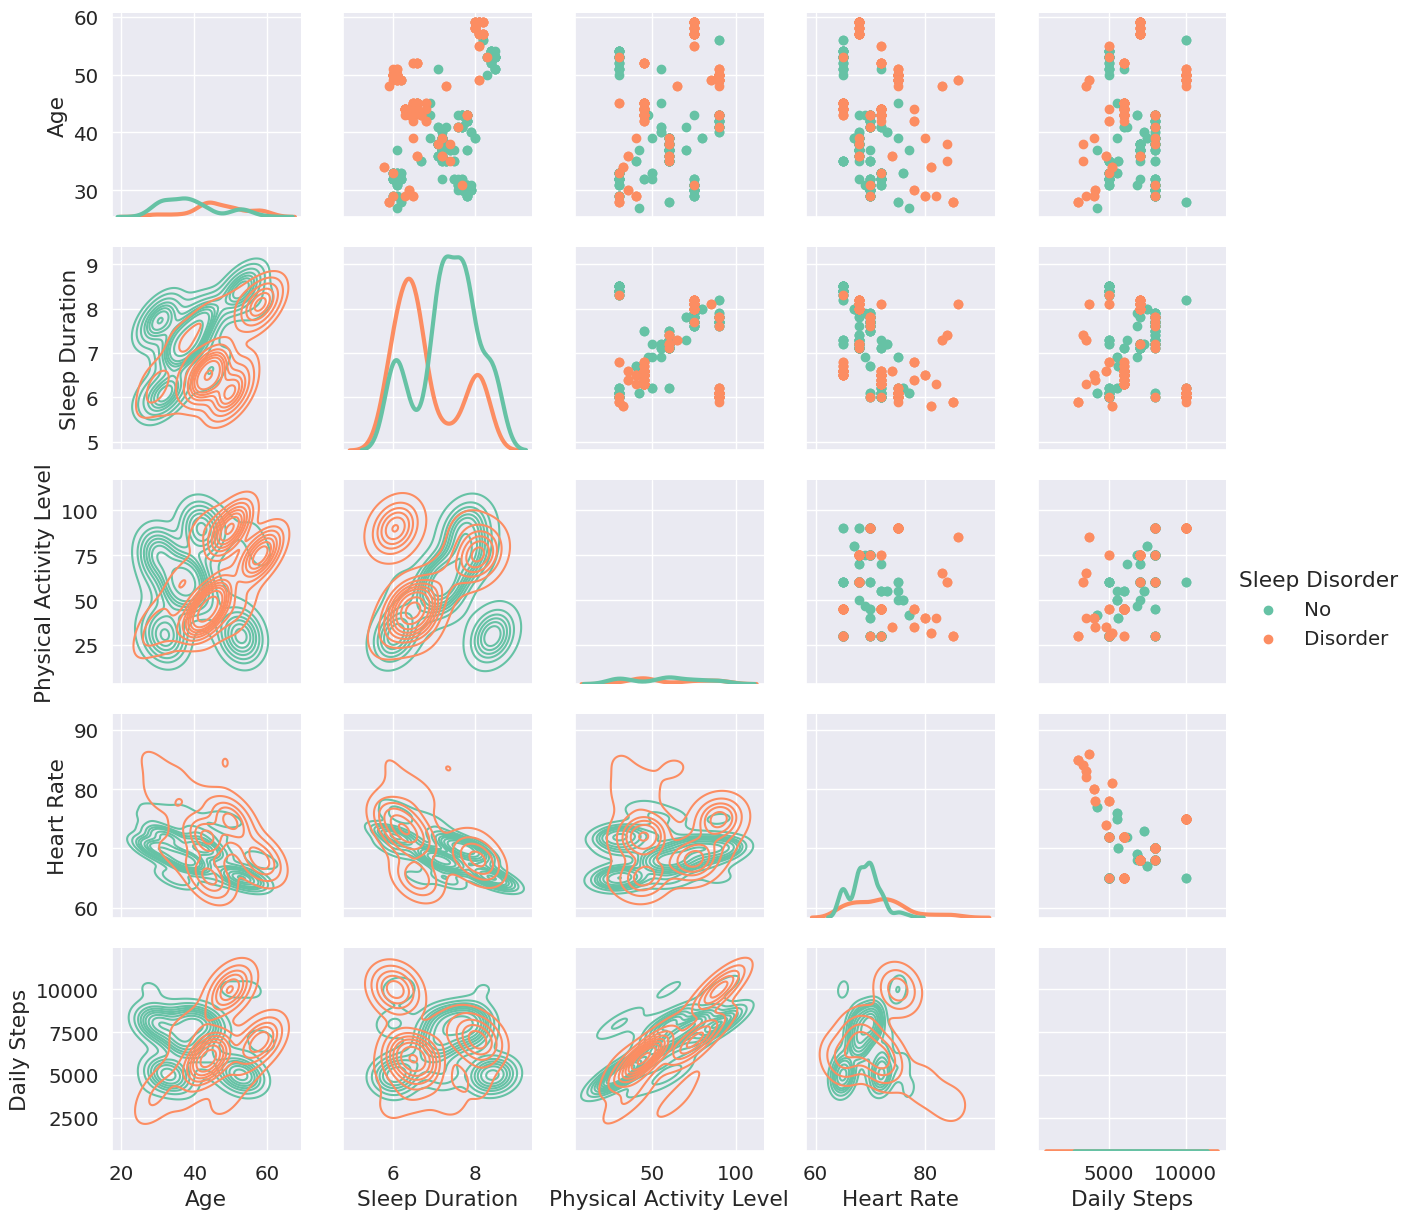

In [ ]:
g = sns.PairGrid(data, hue='Sleep Disorder')
g.map_lower(sns.kdeplot, cmap ="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

g.add_legend()

Насколько сильно отличаются распределения между классами? Есть ли очевидные отличия, сдвиг?

**Вывод:** распределения между классами выглядят отраженными, есть очевидный сдвиг в продолжительности сна, отличие распределений в чсс, также виден сдвиг по возрасту

Оцените, по каким признакам различаются классы, степень различия (сдвиг) и доверительный интервал сдвига. В качестве доверительного интервала используйте бутстрепный квантильный. Объясните выбор статистического теста.

*Подсказка*: выбирая статистический тест и интерпретируя результаты, помните о нулевой гипотезе и мощности. Например, немного об этом в контексте АВ тестов можно почитать [здесь](https://https://habr.com/ru/companies/avito/articles/709596/).

In [ ]:
def shift(x, y):
    '''Вычисление оценки параметра сдвига из критерия ранговых сумм Уилкоксона'''
    W = np.array(x) - np.array(y).reshape(-1, 1)
    return np.median(W)

def estimation(data, target, feature, p_values, shifts, ci_lefts, ci_rights, alpha=0.05):
    '''Вычисление оценки параметра сдвига, бутстрепного доверительного интервала для него, а также величины p-value.

    Аргументы:
    data -- pd.DataFrame данных эксперимента
    target -- название колонки, содержащей информацию о группе (A/B)
    feature -- название колонки с переменной, по которой проводим сравнение между группами
    p_values -- массив для сохранения величины p-value
    shifts -- массив для сохранения величины параметра сдвига
    ci_lefts -- массив для сохранения величины левой границы доверительного интервала
    ci_rights -- массив для сохранения величины правой границы доверительного интервала
    alpha -- уровень значимости
    '''
    boot_shifts = []
    B = 100
    x = data.loc[data[target] == 'Disorder', feature]
    y = data.loc[data[target] == 'No', feature]

    p_values.append(sps.mannwhitneyu(x, y, alternative='two-sided').pvalue)
    shifts.append(shift(x, y))

    for i in range(B):
        x_boot = [np.random.choice(x, size=len(x), replace=True)]
        y_boot = [np.random.choice(y, size=len(y), replace=True)]
        boot_shifts.append(shift(x_boot, y_boot))

    ci_bootst = [np.sort(boot_shifts)[int(np.floor(B*(1-alpha)/2)-1)],
                 np.sort(boot_shifts)[int(np.ceil(B*(1+alpha)/2)-1)]] # бутстрепный доверительный квантильный интервал
    ci_lefts.append(ci_bootst[0])
    ci_rights.append(ci_bootst[1])

In [ ]:
p_values, shifts, ci_lefts, ci_rights = [], [], [], []
for column in tqdm(columns[:-1]):
    estimation(data, 'Sleep Disorder', column, p_values, shifts, ci_lefts, ci_rights, alpha = 0.95)

100%|██████████| 5/5 [00:00<00:00, 15.54it/s]


In [ ]:
results = {'feature': columns[:-1],
           'p_value': p_values,
           'shift': shifts,
           'ci_left': ci_lefts,
           'ci_right': ci_rights}
results = pd.DataFrame(results)

In [ ]:
results

,feature,p_value,shift,ci_left,ci_right
0,Age,2.998305e-18,8.0,6.0,11.0
1,Sleep Duration,3.637710e-09,-0.7,-0.9,-0.5
2,Physical Activity Level,1.687369e-01,0.0,0.0,15.0
3,Heart Rate,7.916085e-08,2.0,2.0,3.0
4,Daily Steps,1.539960e-01,-200.0,-1000.0,0.0


*Замечание.* Строго говоря, необходима поправка на множественное тестирование

Какой тест вы использовали и почему? Какие выводы можно сделать по p-value? Как доверительный интервал соотносится с этими выводами?

**Вывод:** используем непараметрический тест (нет информации о распределениях) и манна-уитни как для независимых, двухсторонняя альтернатива, чтобы проверить одинаково/нет

По значениям p-value наблюдается статистически значимое различие с большой уверенностью между двумя классами по параметрам возраста (наиболее выраженно), продолжительности сна и чсс (иными словами, по p-value меньше уровня значимости 0.05 мы отвергаем гипотезу об отсутствии различий), эти выводы подтверждаются построенными дов интервалами для сдвига потому что ноль в них не входит, зато он входит в интервалы для оставшихся двух параметров, которые мы не смогли отвергнуть по значению p-value

все сдвиги и различия которые предположили из графиков выше нашли статистическое подтверждение